## imports & functions

In [1]:
import pandas as pd
import json 
import os
import codecs
import numpy as np

## main script

In [2]:
query = 'goji'
query_folder = '../data/html/'+query

In [3]:
def split_data_frame_list(df, target_column):
    """
    Splits a column with lists into rows
    
    Keyword arguments:
        df -- dataframe
        target_column -- name of column that contains lists        
    """
    
    # create a new dataframe with each item in a seperate column, dropping rows with missing values
    col_df = pd.DataFrame(df[target_column].dropna().tolist(),index=df[target_column].dropna().index)

    # create a series with columns stacked as rows         
    stacked = col_df.stack()

    # rename last column to 'idx'
    index = stacked.index.rename(names="ingr_id", level=-1)
    new_df = pd.DataFrame(stacked, index=index, columns=[target_column])
    return new_df

def parseIngredients(ingredientStr):
    ingredientStr = ingredientStr.strip()
    ingredientStr = ingredientStr.replace(',','.')
    ingredientStr = ingredientStr.replace('(','').replace(')','')
    ingredientStr = ingredientStr.replace('.00','')
    
    ingredientStr = ingredientStr.replace('Prisen','g')
    ingredientStr = ingredientStr.replace('Spritzer',' g')
    
    ingredientStr = ingredientStr.replace('1 Eier','65 g Ei')
    ingredientStr = ingredientStr.replace('2 Eier','130 g Ei')
    ingredientStr = ingredientStr.replace('3 Eier','195 g Ei')
    ingredientStr = ingredientStr.replace('4 Eier','260 g Ei')
    ingredientStr = ingredientStr.replace('5 Eier','325 g Ei')
    
    ingredientStr = ingredientStr.replace('1 Pck.','7.00 g')
    ingredientStr = ingredientStr.replace('1 Pkt.','7.00 g')
    ingredientStr = ingredientStr.replace('2 Pck.','14.00 g')
    ingredientStr = ingredientStr.replace('0.50 Pck.','3.50 g')
    
    ingredientStr = ingredientStr.replace('1 EL','15.00 g')
    ingredientStr = ingredientStr.replace('2 EL','30.00 g')
    
    ingredientStr = ingredientStr.replace('1 TL','3 g')   
    
    return ingredientStr

def splitIngredients(ingredientStr):
    try:
        ingredientStr = ingredientStr.split(' ')[0]
    except:
        ingredientStr
    
    return ingredientStr

def harmonizeIngredient(ingredientStr):
    if 'zucker' in ingredientStr: 
        ingredientStr = 'Zucker'
        
    if "mehl" in ingredientStr:
        ingredientStr = 'Mehl'
 
    return ingredientStr

## parse saved html files to dataframe

In [5]:
recipe_values = []

for file in os.listdir(query_folder):
    if file.endswith(".html"):
        recipe_id = file.split('.html')[0]
        html_doc = os.path.join(query_folder, file)
        html_string = codecs.open(html_doc,'r', encoding="utf8").read()
        
        recipe_json = html_string.split('<script type="application/ld+json">')[2].split('</script>')[0]
        recipe_dict = json.loads(recipe_json)
        
        try:
            rating = float(recipe_dict['aggregateRating']['ratingValue'])
        except:
            rating = None
        
        try:
            ingredients = recipe_dict['recipeIngredient']
        except Exception as r:
            print(r)
            ingredients = []
            
        try:
            datePublished = recipe_dict['datePublished']
        except Exception as r:
            datePublished = None
        
        values = (recipe_id, datePublished, rating, ingredients)
        recipe_values.append(values)
        
df = pd.DataFrame(recipe_values)
df.columns = ['recipe_id', 'datePublished', 'rating','ingredients']
df['datePublished'] =  pd.to_datetime(df['datePublished'], format='%Y-%m-%d')
df = df.set_index('datePublished')

## recipes by quarter

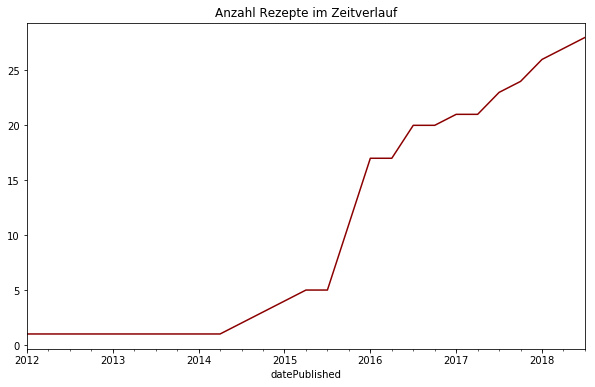

In [7]:
years = df.resample('q').count()
years = years.cumsum()
years.to_excel('../data/xlsx/'+query+'.xlsx')
years['recipe_id'].plot(title='Anzahl Rezepte im Zeitverlauf', figsize=(10,6), color='darkred')

## parse ingredients

In [27]:
# convert ingredients column to rows
df_ingredients = split_data_frame_list(df, target_column="ingredients")
df_ingredients = df_ingredients.reset_index()
df = df.drop(['ingredients'], axis=1)

# merge dataframes
df = df.reset_index()
df_merge = df.merge(df_ingredients, how='outer', on='recipe_id')

# drop recipes without rating
df_merge = df_merge.dropna(subset = ['rating'])

# parse ingredients, filter for gram values and create corresponding columns
df_merge['ingredients'] = df_merge['ingredients'].apply(parseIngredients)
df_merge = df_merge[df_merge['ingredients'].str.contains(' g ')]

temp = df_merge["ingredients"].str.split(" g ", n = 1, expand = True) 
df_merge["amount"] = temp[0]
df_merge["amount"] = df_merge["amount"].astype(float, errors='ignore')
df_merge["ingredient"] = temp[1]
df_merge['ingredient'] = df_merge['ingredient'].apply(splitIngredients)
df_merge['ingredient'] = df_merge['ingredient'].apply(harmonizeIngredient)

df_merge = df_merge.drop(['ingredients'], axis=1)

df_merge.head()

,recipe_id,rating,ingr_id,amount,ingredient
2,1001121205401243,3.15,2,40,Zucker
3,1001121205401243,3.15,3,1,Salz
5,1001121205401243,3.15,5,180,Mehl
6,1001121205401243,3.15,6,7.00,Backpulver
11,1003191205518741,2.60,2,7.00,Puddingpulver


In [80]:
df_merge.to_excel('test.xlsx')